In [15]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial 

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from Pairwise import * 

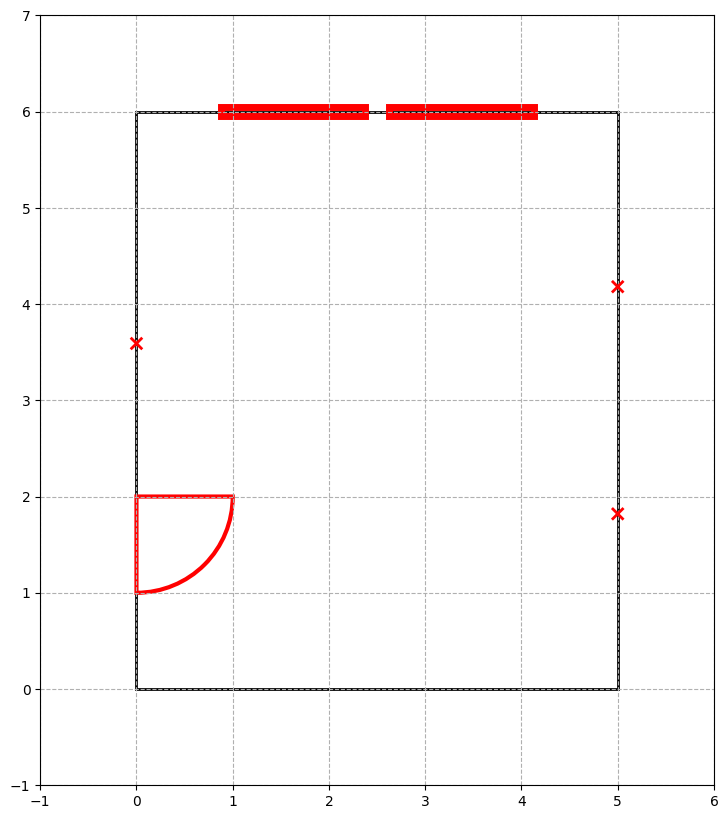

New best result found. Cost:  7.9844517395731645
New best result found. Cost:  1.6355281296166507e-05


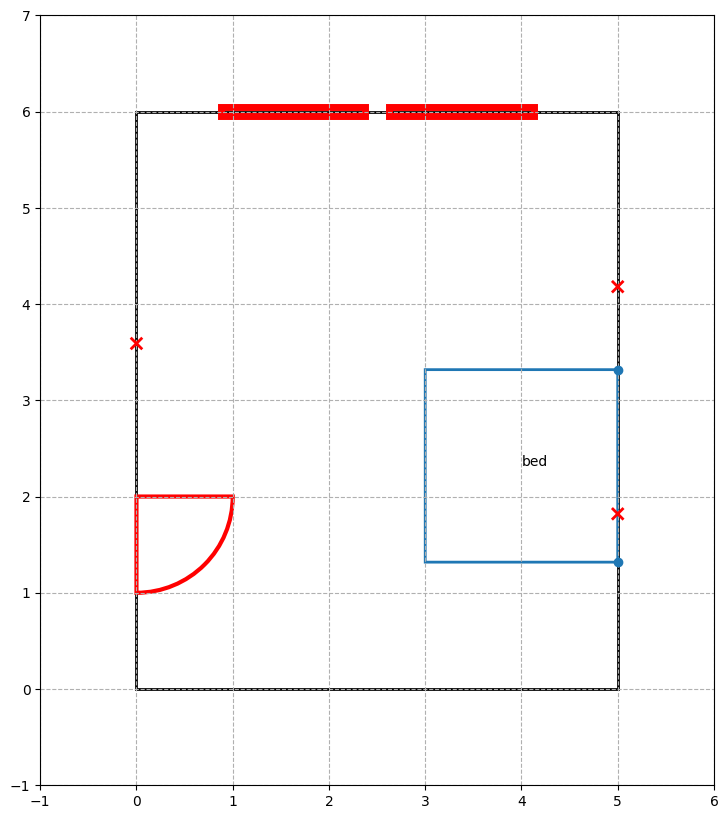

New best result found. Cost:  7.251579074337439
New best result found. Cost:  0.5261060858160723
New best result found. Cost:  0.3115605876247264


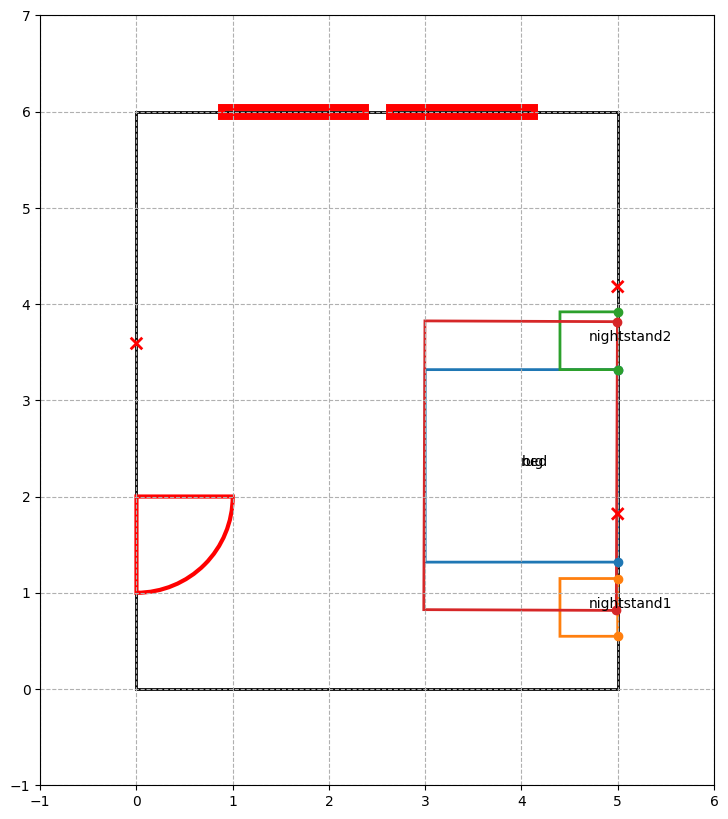

In [16]:
room = create_room(5, 6)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.25)
create_fixed_object(room, 'window', 1.5, 0.1, 'north', position = 0.75)
create_fixed_object(room, 'door', 1, 0.1, 'west', position = 0.2)
create_fixed_object(room, 'socket', 0.1, 0.05, 'west', position = 0.6)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.3)
create_fixed_object(room, 'socket', 0.1, 0.05, 'east', position = 0.7)
room.draw()

options = {'maxiter': 300, 'ftol': 1e-6}
sleep = region_setup(room, 'sleeping', 0)
create_moving_object(room, 'bed', 2, 2, 'sleeping', 0)

def optimize_primary_objects(positions, room): 
    
    output = 0
    output += ind_next_to_wall(positions, room, 0, 'back')  # bed
    output += ind_close_to_fixed_object(positions, room, 0, 'socket', side = 'back')
    output += ind_away_from_fixed_object(positions, room, 0, 'window')
    output += ind_away_from_fixed_object(positions, room, 0, 'door')
    output += ind_central(positions, room, 0)
    output += ind_accessible(positions, room, 0, ['left', 'front'])  # bed
    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)

    return output

iters = 0
min_fun = np.Inf
while min_fun > 1e-2 and iters < 15:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects, positions, args = (room), method = 'SLSQP', options = options) 
    iters += 1
    if res.fun < min_fun:
        if not ind_no_overlap(res.x, room) > 0.4 and not ind_in_bounds(res.x, room) > 0.4:
            min_fun = res.fun
            best_res = res
            print("New best result found. Cost: ", min_fun)

    
for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 
room.draw() 

room.regions[0].x, room.regions[0].y = room.moving_objects[0].position[0], room.moving_objects[0].position[1]
prev_cost = min_fun 

create_moving_object(room, 'nightstand1', 0.6, 0.6, 'sleeping', 1)
create_moving_object(room, 'nightstand2', 0.6, 0.6, 'sleeping', 2)
create_moving_object(room, 'rug', 3, 2, 'sleeping', 3)

def optimize_secondary_objects(positions, room):
    output = 0
    output += FIX(positions, room, [0])
    output += 0.2*optimize_primary_objects(positions, room)

    output += ind_next_to_wall(positions, room, 1, 'back')  # nightstand1
    output += ind_next_to_wall(positions, room, 2, 'back')  # nightstand2
    output += p_between(positions, room, 0, 1, 2)  # nightstand1, nightstand2
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += p_next_to(positions, room, 1, 0, 'right', 'left')  # nightstand1, bed
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2

    output += p_under_central(positions, room, 3, 0) # rug, bed
    output += ind_not_against_wall(positions, room, 3) # rug

    output += ind_in_region(positions, room, 1, 'sleeping')
    output += ind_in_region(positions, room, 2, 'sleeping')
    output += ind_in_region(positions, room, 3, 'sleeping')

    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)

    return output

bounds = bounds = Bounds([-10] * 3 * len(room.moving_objects), [room.width + 10, room.length + 10, np.Inf] * len(room.moving_objects))
iters = 0
min_fun = np.Inf
while min_fun > prev_cost + 5e-2 and iters < 15:
    positions = np.zeros(3*len(room.moving_objects))
    positions[0:3] = room.moving_objects[0].position
    for i in range(1, len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds) 
    iters += 1
    if res.fun < min_fun:
        if not ind_no_overlap(res.x, room) > 0.4 and not ind_in_bounds(res.x, room) > 0.4:
            min_fun = res.fun
            best_res = res
            print("New best result found. Cost: ", min_fun)

    
for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 
room.draw() 

room.regions[0].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'sleeping'])
room.regions[0].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'sleeping'])

prev_cost = min_fun 

New best result found. Cost:  4.76038476899188
New best result found. Cost:  2.396528237686872
New best result found. Cost:  1.2123153144049663
New best result found. Cost:  1.2028284846459498
New best result found. Cost:  1.0810237736399897


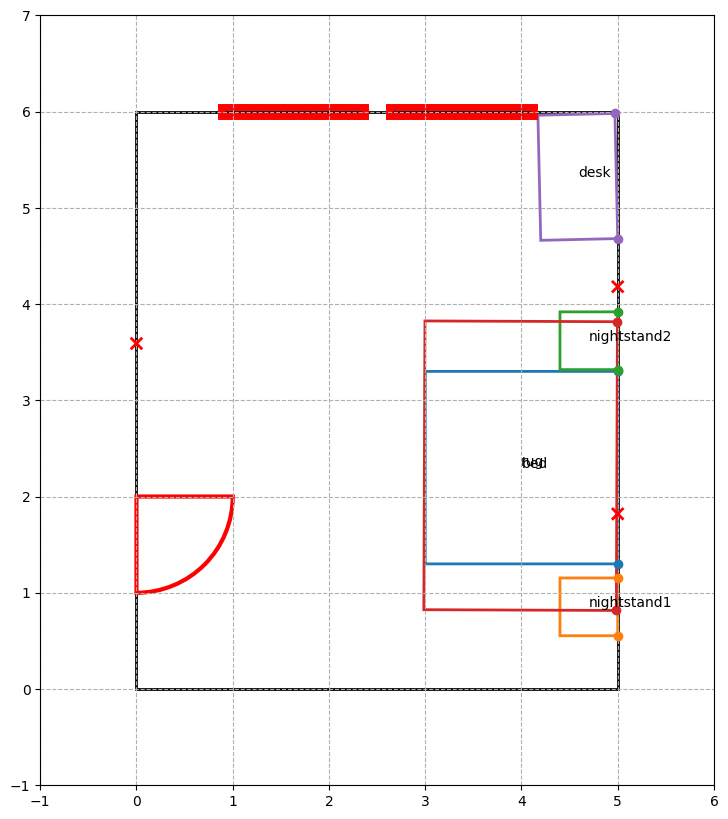

New best result found. Cost:  1.2535981476984732
New best result found. Cost:  0.5752883377906922


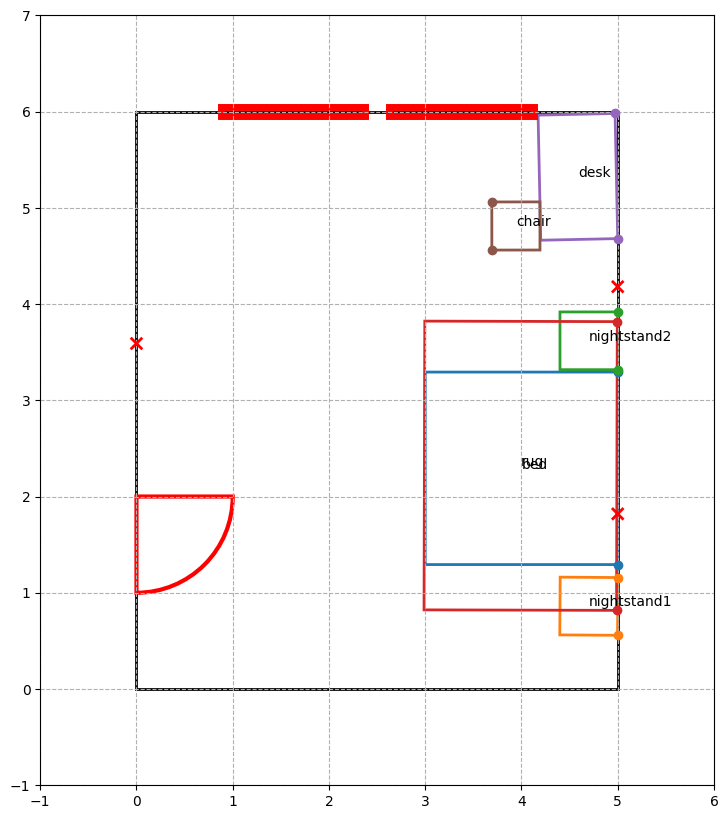

In [17]:
## Region 2
working = region_setup(room, 'working', 1)
create_moving_object(room, 'desk', 1.3, 0.8, 'working', 4)

def optimize_primary_objects2(positions, room):
    output = 0
    output += FIX(positions, room, [0, 1, 2, 3])
    output += 0.2*optimize_primary_objects(positions, room)
    output += 0.2*optimize_secondary_objects(positions, room)

    output += ind_next_to_wall(positions, room, 4, 'back')  # desk
    output += ind_close_to_fixed_object(positions, room, 4, 'socket')
    output += ind_close_to_fixed_object(positions, room, 4, 'window')
    output += p_away_from(positions, room, 4, 0)  # desk, bed

    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)

    return output

bounds = bounds = Bounds([-10] * 3 * len(room.moving_objects), [room.width + 10, room.length + 10, np.Inf] * len(room.moving_objects))
iters = 0
min_fun = np.Inf
while min_fun > prev_cost + 0.1 and iters < 15:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.moving_objects) - 1):
        positions[3*i] = room.moving_objects[i].position[0]
        positions[3*i + 1] = room.moving_objects[i].position[1]
        positions[3*i + 2] = room.moving_objects[i].position[2] 
    for i in range(len(room.moving_objects) - 1, len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects2, positions, args = (room), method = 'SLSQP', options = options, bounds=bounds) 
    iters += 1
    if res.fun < min_fun:
        if not ind_no_overlap(res.x, room) > 0.4 and not ind_in_bounds(res.x, room) > 0.4:
            min_fun = res.fun
            best_res = res
            print("New best result found. Cost: ", min_fun)

for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 
room.draw() 

room.regions[1].x, room.regions[1].y = room.moving_objects[4].position[0], room.moving_objects[4].position[1]
prev_cost = min_fun

create_moving_object(room, 'chair', 0.5, 0.5, 'working', 5)

def optimize_secondary_objects2(positions, room):

    output = 0
    output += FIX(positions, room, [0, 1, 2, 3, 4])
    output += 0.2*optimize_primary_objects(positions, room)
    output += 0.2*optimize_secondary_objects(positions, room)
    output += 0.2*optimize_primary_objects2(positions, room)

    output += p_next_to(positions, room, 5, 4, 'front', 'front')
    output += ind_in_region(positions, room, 5, 'working')

    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)

    return output 

bounds = bounds = Bounds([-10] * 3 * len(room.moving_objects), [room.width + 10, room.length + 10, np.Inf] * len(room.moving_objects))
iters = 0
min_fun = np.Inf

while min_fun > prev_cost + 0.1 and iters < 15:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.moving_objects) - 1):
        positions[3*i] = room.moving_objects[i].position[0]
        positions[3*i + 1] = room.moving_objects[i].position[1]
        positions[3*i + 2] = room.moving_objects[i].position[2] 
    for i in range(len(room.moving_objects) - 1, len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects2, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds) 
    iters += 1
    if res.fun < min_fun:
        if not ind_no_overlap(res.x, room) > 0.4 and not ind_in_bounds(res.x, room) > 0.4:
            min_fun = res.fun
            best_res = res
            print("New best result found. Cost: ", min_fun)

for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 
room.draw() 

prev_cost = 1.0 * min_fun 

room.regions[1].x = np.mean([i.position[0] for i in room.moving_objects if i.region == 'working'])
room.regions[1].y = np.mean([i.position[1] for i in room.moving_objects if i.region == 'working'])

Iteration 0
New best result found. Cost:  13.478890412544642
Iteration 1
Iteration 2
New best result found. Cost:  1.1709258531355335
Iteration 3
New best result found. Cost:  0.8320897532364838
Iteration 4
Iteration 5
Iteration 6
Iteration 7
New best result found. Cost:  0.8272999034102807
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14


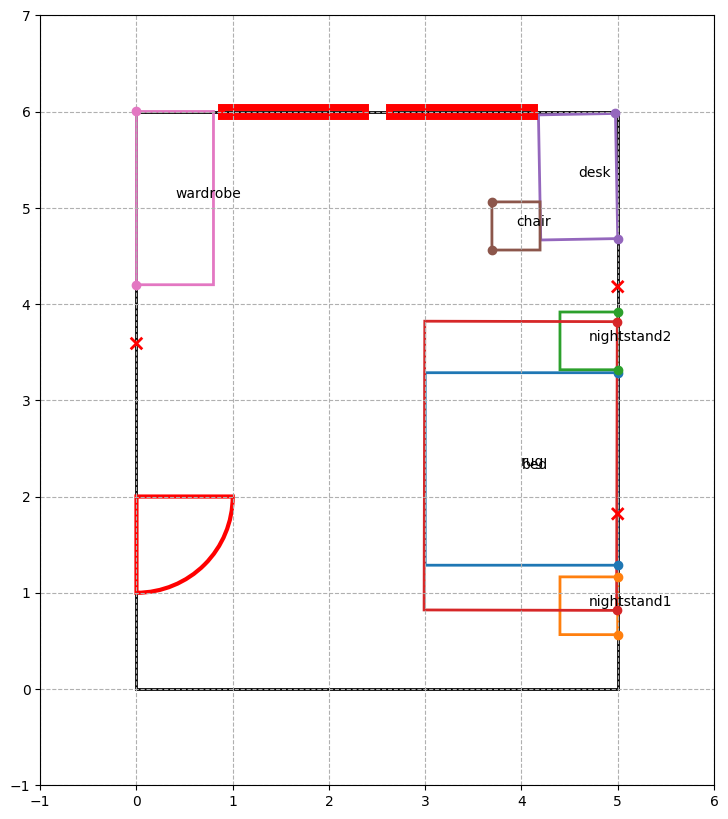

Iteration 0
New best result found. Cost:  0.9822234172381564
Iteration 1
Iteration 2
Iteration 3
New best result found. Cost:  0.8013241593749533


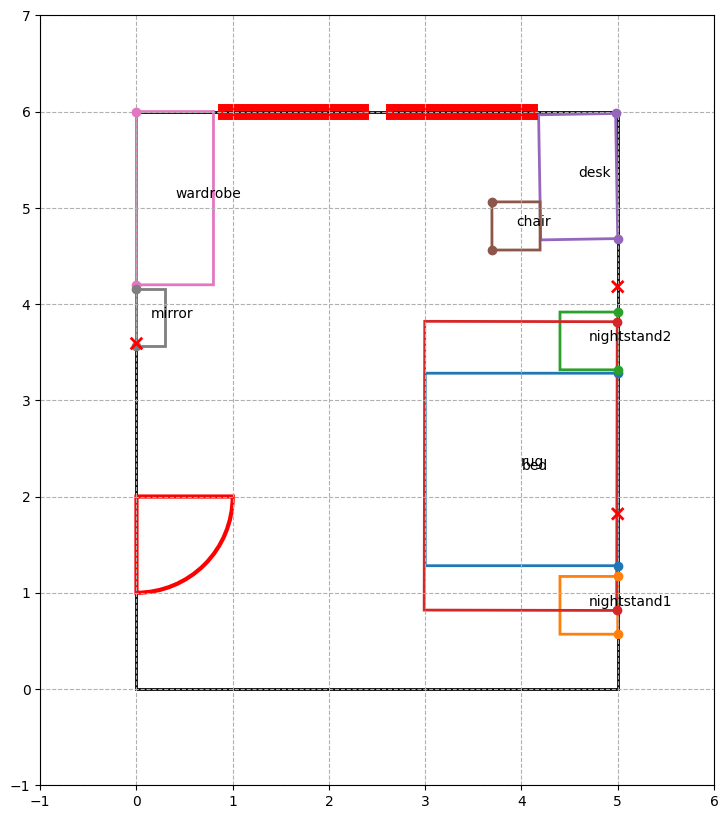

In [18]:
## Region 3

options = {'maxiter': 150, 'ftol': 1e-5}
storage = region_setup(room, 'storage/dressing', 2)
create_moving_object(room, 'wardrobe', 1.8, 0.8, 'storage/dressing', 6)

def optimize_primary_objects3(positions, room):
    output = 0
    output += FIX(positions, room, [0, 1, 2, 3, 4, 5])

    output += 0.2*optimize_primary_objects(positions, room)
    output += 0.2*optimize_secondary_objects(positions, room)
    output += 0.2*optimize_primary_objects2(positions, room)
    output += 0.2*optimize_secondary_objects2(positions, room)
    
    output += ind_next_to_wall(positions, room, 6, 'back')  # wardrobe
    output += ind_accessible(positions, room, 6, ['front'])
    output += ind_not_block_fixed_object(positions, room, 6, 'window')

    output += p_away_from(positions, room, 6, 0)  # wardrobe, bed
    output += p_away_from(positions, room, 6, 4)  # wardrobe, desk

    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)

    return output

bounds = bounds = Bounds([-10] * 3 * len(room.moving_objects), [room.width + 10, room.length + 10, np.Inf] * len(room.moving_objects))
iters = 0
min_fun = np.Inf
while min_fun > prev_cost + 0.1 and iters < 15:
    print(f"Iteration {iters}")
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.moving_objects) - 1):
        positions[3*i] = room.moving_objects[i].position[0]
        positions[3*i + 1] = room.moving_objects[i].position[1]
        positions[3*i + 2] = room.moving_objects[i].position[2] 
    for i in range(len(room.moving_objects) - 1, len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_primary_objects3, positions, args = (room), method = 'SLSQP', options = options, bounds=bounds) 
    iters += 1
    if res.fun < min_fun:
        if not ind_no_overlap(res.x, room) > 0.4 and not ind_in_bounds(res.x, room) > 0.4:
            min_fun = res.fun
            best_res = res
            print("New best result found. Cost: ", min_fun)

for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 
room.draw() 

room.regions[2].x, room.regions[2].y = room.moving_objects[6].position[0], room.moving_objects[6].position[1]
prev_cost = min_fun

create_moving_object(room, 'mirror', 0.6, 0.3, 'storage/dressing', 7)

def optimize_secondary_objects3(positions, room):

    output = 0
    output += FIX(positions, room, [0, 1, 2, 3, 4, 5, 6])
    output += 0.2*optimize_primary_objects(positions, room)
    output += 0.2*optimize_secondary_objects(positions, room)
    output += 0.2*optimize_primary_objects2(positions, room)
    output += 0.2*optimize_secondary_objects2(positions, room)
    output += 0.2*optimize_primary_objects3(positions, room)

    output += ind_in_region(positions, room, 7, 'storage/dressing')
    output += ind_next_to_wall(positions, room, 7, 'back')  # mirror
    output += ind_accessible(positions, room, 7, ['front'])
    output += ind_aligned(positions, room)
    output += ind_no_overlap(positions, room)
    output += ind_in_bounds(positions, room)

    return output 

bounds = bounds = Bounds([-10] * 3 * len(room.moving_objects), [room.width + 10, room.length + 10, np.Inf] * len(room.moving_objects))
iters = 0
min_fun = np.Inf

while min_fun > prev_cost + 0.1 and iters < 15:
    print(f"Iteration {iters}")
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.moving_objects) - 1):
        positions[3*i] = room.moving_objects[i].position[0]
        positions[3*i + 1] = room.moving_objects[i].position[1]
        positions[3*i + 2] = room.moving_objects[i].position[2] 
    for i in range(len(room.moving_objects) - 1, len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(optimize_secondary_objects3, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds) 
    iters += 1
    if res.fun < min_fun:
        if not ind_no_overlap(res.x, room) > 0.4 and not ind_in_bounds(res.x, room) > 0.4:
            min_fun = res.fun
            best_res = res
            print("New best result found. Cost: ", min_fun)

for i in range(len(room.moving_objects)): 
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 
room.draw() 


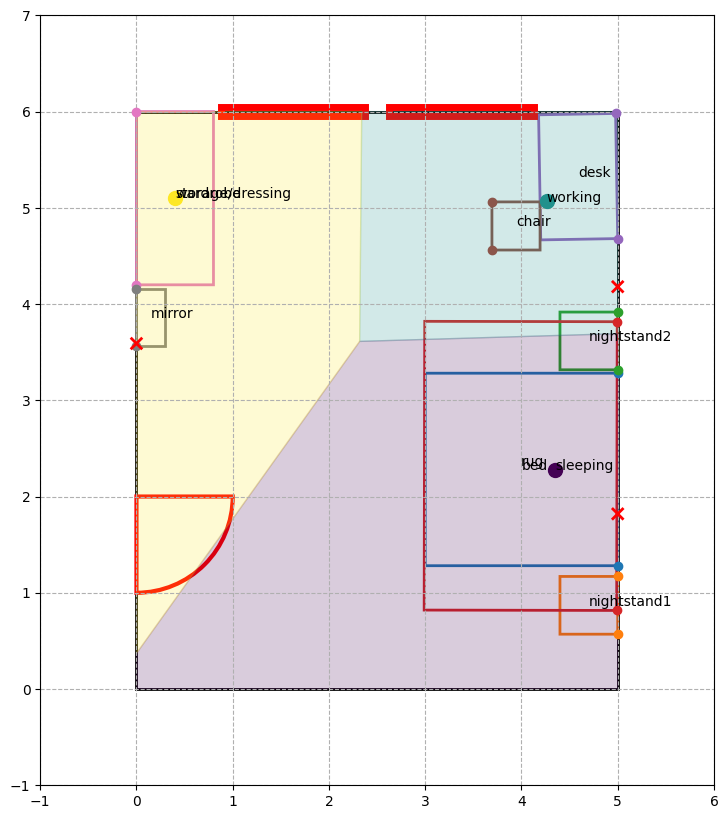

In [19]:
room.draw(draw_regions = True)